In [4]:
pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/84/57/2f64161769610cf6b1c5ed782bd8a780e18a3c9d48931319f2887fa9d0b1/torch-2.8.0-cp311-cp311-win_amd64.whl.metadata
  Using cached torch-2.8.0-cp311-cp311-win_amd64.whl.metadata (30 kB)
  Obtaining dependency information for typing-extensions>=4.10.0 from https://files.pythonhosted.org/packages/18/67/36e9267722cc04a6b9f15c7f3441c2363321a3ea07da7ae0c0707beb2a9c/typing_extensions-4.15.0-py3-none-any.whl.metadata
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Obtaining dependency information for sympy>=1.13.3 from https://files.pythonhosted.org/packages/a2/09/77d55d46fd61b4a135c444fc97158ef34a095e5681d0a6c10b75bf356191/sympy-1.14.0-py3-none-any.whl.metadata
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/241.4 MB ? eta -:--:--
   ---------------------------------------- 0.2/241.4 MB 5.3 MB/s eta 0:00:46
   -----

In [1]:
# G0) 环境与设备（如无 torch 尝试安装；失败则提示）
import sys, subprocess, importlib

def ensure_pkg(pkg):
    try:
        importlib.import_module(pkg)
        print(f"{pkg} 已安装")
        return True
    except:
        print(f"{pkg} 未安装，尝试安装...")
        try:
            _ = get_ipython()
            if _ is not None:
                get_ipython().run_line_magic('pip', f'install -q {pkg}')
            else:
                subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
            importlib.import_module(pkg)
            print(f"{pkg} 安装成功")
            return True
        except Exception as e:
            print(f"{pkg} 安装失败：{e}")
            return False

ok_torch = ensure_pkg('torch')
ok_tqdm  = ensure_pkg('tqdm')

assert ok_torch, "未能安装/导入 PyTorch，CNN/RNN 无法运行。可先用 SVM 流程；或手动装 torch 再重试。"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用设备：", device)
torch.manual_seed(42)


torch 已安装
tqdm 已安装
使用设备： cpu


In [2]:
# G1_fix) 一键自修：缺什么补什么 → 行为特征 + 二分类标签 + 序列化索引矩阵
import numpy as np, pandas as pd, re

# ========== 0) 兜底读取数据（如果 df 未定义） ==========
if 'df' not in globals():
    try:
        df = pd.read_csv(r"CNAH2003_public_use.csv", low_memory=False)
        print("已从默认路径加载 df。")
    except Exception as e:
        raise RuntimeError("未找到 df 且默认路径读取失败，请先把 df 加载到内存，再运行本单元。\n"
                           "示例：df = pd.read_csv(r'AAAcss project/CNAH2003_public_use.csv')") from e

N = len(df)

# ========== 1) 如果没有 behavior_feature_cols，就用“值模式”自动筛行为特征 ==========
if 'behavior_feature_cols' not in globals() or len(behavior_feature_cols)==0:
    LEAKS = {c for c in ['Q38','QN24','Q39','QN25','Q40','QN26'] if c in df.columns}
    EXCLUDE_KW = {'height','身高','weight','体重','bmi','age','年龄','sex','gender','性别','grade','年级','id','name','uuid','uid'}

    def name_excluded(col):
        low = str(col).lower()
        return any(k in low for k in EXCLUDE_KW)

    def looks_like_likert(series: pd.Series):
        s = pd.to_numeric(series, errors='coerce').dropna()
        if s.empty: return False
        vals = s.unique()
        in_small_range = np.all((vals >= 0) & (vals <= 7) & (np.mod(vals,1)==0))
        nunq = len(np.unique(vals))
        return in_small_range and (3 <= nunq <= 7)

    def looks_like_small_count(series: pd.Series):
        s = pd.to_numeric(series, errors='coerce').dropna()
        if s.empty: return False
        vals = s.unique()
        in_range = np.all((vals >= 0) & (vals <= 12) & (np.mod(vals,1)==0))
        return in_range and (len(vals) >= 3)

    def looks_like_small_category(series: pd.Series, max_card=12):
        nunq = series.nunique(dropna=True)
        return (series.dtype == 'object' or series.dtype.name == 'category') and (2 <= nunq <= max_card)

    def is_identifier(series: pd.Series):
        nunq = series.nunique(dropna=True)
        return nunq > 0.9 * len(series)

    def is_anthro_by_value(series: pd.Series):
        s = pd.to_numeric(series, errors='coerce').dropna()
        if s.empty: return False
        nunq = s.nunique()
        if nunq < 15: return False
        med = s.median()
        if 120 <= med <= 190: return True   # height (cm)
        if 30  <= med <= 120: return True   # weight (kg)
        if 8   <= med <= 20:  return True   # age (years)
        if 12  <= med <= 40 and s.mean()<50 and s.std()<20: return True  # possible BMI
        return False

    behavior_feature_cols = []
    for c in df.columns:
        if c in LEAKS: continue
        if name_excluded(c): continue
        col = df[c]
        if col.notna().sum() <= 0.02 * N: continue
        if col.nunique(dropna=True) <= 1: continue
        if is_identifier(col): continue
        if is_anthro_by_value(col): continue
        if looks_like_likert(col) or looks_like_small_count(col) or looks_like_small_category(col, max_card=12):
            behavior_feature_cols.append(c)

    # 若仍然为 0，放宽一档（类别基数上限 20；计数上限 24）
    if len(behavior_feature_cols) == 0:
        for c in df.columns:
            if c in LEAKS: continue
            if name_excluded(c): continue
            col = df[c]
            if col.notna().sum() <= 0.02 * N: continue
            if col.nunique(dropna=True) <= 1: continue
            if is_identifier(col): continue
            if is_anthro_by_value(col): continue
            if looks_like_likert(col) or looks_like_small_count(col) \
               or ((col.dtype=='object' or col.dtype.name=='category') and 2 <= col.nunique(dropna=True) <= 20):
                behavior_feature_cols.append(c)

    behavior_feature_cols = behavior_feature_cols[:120]
    print(f"[G1_fix] 行为特征数：{len(behavior_feature_cols)}")
    if len(behavior_feature_cols) == 0:
        raise RuntimeError("仍然没有找到行为特征。建议：\n"
                           "1) 确认 df 已正确加载；2) 放宽规则；或 3) 给出 codebook 中明确的行为题列名列表。")
else:
    print(f"[G1_fix] 复用已有行为特征列：{len(behavior_feature_cols)}")

# ========== 2) 如果没有 y_bin，就基于 Q38/Q39 生成二分类标签 ==========
def _norm_token(x):
    s = str(x).strip().lower()
    try:
        f = float(s)
        if float(int(f)) == f:
            return str(int(f))
        return s
    except Exception:
        return s

YES_TOKENS_TEXT = {'yes','y','true','是','有'}

def is_yes_value(val, mapping):
    if pd.isna(val): return False
    s = _norm_token(val)
    if s in mapping.get('invalid', set()): return False
    if s in YES_TOKENS_TEXT: return True
    return s == mapping.get('yes_token')

# 列名兜底
Q38 = 'Q38' if 'Q38' in df.columns else ('QN24' if 'QN24' in df.columns else 'Q38')
Q39 = 'Q39' if 'Q39' in df.columns else ('QN25' if 'QN25' in df.columns else 'Q39')
MAP38 = {'scheme':'12','yes_token':'2','no_token':'1','invalid': {'3','4','3.0','4.0'}}
MAP39 = {'scheme':'12','yes_token':'2','no_token':'1','invalid': {'3','4','3.0','4.0'}}

if 'y_bin' not in globals():
    LABEL_STRATEGY = 'Q38_or_Q39'   # 如需只用 Q39：改为 'Q39_only'
    def make_binary_label(row):
        if LABEL_STRATEGY == 'Q39_only':
            return 1 if is_yes_value(row[Q39], MAP39) else 0
        else:
            return int(is_yes_value(row[Q39], MAP39) or is_yes_value(row[Q38], MAP38))
    df['_y_bin'] = df.apply(make_binary_label, axis=1)
    y_bin = df['_y_bin'].astype(int)
    print("二分类标签分布：", y_bin.value_counts().to_dict())
else:
    print("复用已有 y_bin。")

# ========== 3) 将“行为特征”序列化为索引矩阵（每列一个 vocab，0 作为 padding） ==========
X_beh = df[behavior_feature_cols].copy()

def discretize_numeric(series, nbins=5):
    s = pd.to_numeric(series, errors='coerce')
    if s.notna().sum() < 50:
        return None, None
    try:
        bins = np.unique(np.quantile(s.dropna(), np.linspace(0, 1, nbins+1)))
        if len(bins) <= 2:
            return None, None
        idx = np.digitize(s, bins[1:-1], right=False) + 1  # 1..NBINS；0=padding
        vocab_size = (len(bins)-1) + 1
        return idx.fillna(0).astype(int), vocab_size
    except Exception:
        return None, None

def factorize_categorical(series, max_card=12):
    nunq = series.nunique(dropna=True)
    if nunq<2 or nunq>max_card:
        return None, None
    codes, uniques = pd.factorize(series, sort=True)
    codes = pd.Series(codes, index=series.index).replace({-1:0}).astype(int)  # -1→0 padding
    vocab_size = len(uniques) + 1
    return codes, vocab_size

idx_cols, vocab_sizes, encoders_meta = [], [], []
for c in behavior_feature_cols:
    s = X_beh[c]
    idx, vsz = discretize_numeric(s, nbins=5)
    mode = None
    if idx is not None:
        mode = ('num_bins', 5)
    else:
        idx, vsz = factorize_categorical(s, max_card=12)
        if idx is not None:
            mode = ('cat_fact', min(12, s.nunique(dropna=True)))
    if idx is None:
        continue
    idx_cols.append(idx)
    vocab_sizes.append(int(vsz))
    encoders_meta.append((c, mode, int(vsz)))

if len(idx_cols)==0:
    raise RuntimeError("没有任何行为列能被离散化/因子化。请放宽规则或提供具体列名。")

X_idx = np.vstack([col.values for col in idx_cols]).T   # [N, T]
y_arr = y_bin.values.astype(int)
T = X_idx.shape[1]
print(f"序列化完成：X_idx 形状={X_idx.shape}（N, T），T={T}; 前10个 vocab_sizes={vocab_sizes[:10]}")


已从默认路径加载 df。
[G1_fix] 行为特征数：40
二分类标签分布： {0: 2244, 1: 104}
序列化完成：X_idx 形状=(2348, 40)（N, T），T=40; 前10个 vocab_sizes=[7, 5, 6, 8, 8, 6, 6, 6, 6, 9]


In [3]:
# G2) 数据集与 DataLoader
class SeqDataset(Dataset):
    def __init__(self, X_idx, y=None):
        self.X = torch.tensor(X_idx, dtype=torch.long)
        self.y = None if y is None else torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, i):
        if self.y is None:
            return self.X[i]
        return self.X[i], self.y[i]

def make_loaders(train_idx, val_idx, batch_size=128, shuffle=True):
    ds_tr = SeqDataset(X_idx[train_idx], y_arr[train_idx])
    ds_va = SeqDataset(X_idx[val_idx], y_arr[val_idx])
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=shuffle, drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, drop_last=False)
    return dl_tr, dl_va


In [4]:
# G3) 两个模型：CNN1D 与 BiGRU
import math
import torch.nn.functional as F

def compute_embed_dims(vocab_sizes):
    # 常用启发式：min(32, round(1.6*sqrt(v)))
    dims = [int(min(32, max(4, round(1.6*math.sqrt(v))))) for v in vocab_sizes]
    return dims

EMBED_DIMS = compute_embed_dims(vocab_sizes)  # 每个位置一个 embedding 维度
EMB_DIM_MAX = int(np.median(EMBED_DIMS))      # 统一投影到相同维度（便于卷积/RNN）

class ColumnEmbedding(nn.Module):
    """每个列一个独立的 Embedding，然后投影到统一维度，最后拼成 [B, T, D]."""
    def __init__(self, vocab_sizes, out_dim, padding_idx=0, p_drop=0.1):
        super().__init__()
        self.T = len(vocab_sizes)
        self.embs = nn.ModuleList([nn.Embedding(v, min(32, max(4, round(1.6*math.sqrt(v)))) , padding_idx=padding_idx)
                                   for v in vocab_sizes])
        self.proj = nn.ModuleList([nn.Linear(self.embs[i].embedding_dim, out_dim) for i in range(self.T)])
        self.dropout = nn.Dropout(p_drop)
    def forward(self, x):  # x: [B, T] (long)
        outs = []
        for i in range(self.T):
            e = self.embs[i](x[:, i])        # [B, e_i]
            p = self.proj[i](e)              # [B, D]
            outs.append(p)
        E = torch.stack(outs, dim=1)         # [B, T, D]
        return self.dropout(E)

class CNN1DClassifier(nn.Module):
    def __init__(self, vocab_sizes, d_model=EMB_DIM_MAX, n_classes=1):
        super().__init__()
        self.embed = ColumnEmbedding(vocab_sizes, out_dim=d_model, p_drop=0.1)
        # Conv1d expects [B, C, T]，我们把 D 当通道数
        ks = [3,5,7]
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=d_model, out_channels=64, kernel_size=k, padding=k//2)
                                    for k in ks])
        self.bn = nn.BatchNorm1d(64*len(ks))
        self.fc = nn.Sequential(
            nn.Linear(64*len(ks), 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_classes)
        )
    def forward(self, x):
        # x: [B, T]
        E = self.embed(x)                     # [B, T, D]
        X = E.transpose(1,2)                  # [B, D, T]
        feats = []
        for conv in self.convs:
            z = F.relu(conv(X))               # [B, 64, T]
            z = F.adaptive_max_pool1d(z, 1).squeeze(-1)  # [B, 64]
            feats.append(z)
        H = torch.cat(feats, dim=1)           # [B, 64*len(ks)]
        H = self.bn(H)
        logit = self.fc(H).squeeze(-1)        # [B]
        return logit

class BiGRUClassifier(nn.Module):
    def __init__(self, vocab_sizes, d_model=EMB_DIM_MAX, hidden=96, n_layers=1, bidir=True, n_classes=1):
        super().__init__()
        self.embed = ColumnEmbedding(vocab_sizes, out_dim=d_model, p_drop=0.1)
        self.gru = nn.GRU(input_size=d_model, hidden_size=hidden, num_layers=n_layers,
                          bidirectional=bidir, batch_first=True, dropout=0.0)
        out_dim = hidden*(2 if bidir else 1)
        self.fc = nn.Sequential(
            nn.Linear(out_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_classes)
        )
    def forward(self, x):
        E = self.embed(x)              # [B, T, D]
        H, _ = self.gru(E)             # [B, T, 2H]
        # masked mean pooling（这里假设 0 = padding，实际上我们已将缺失转为 0）
        # 但每个位置都有值(>=0)，故直接 mean-pool
        Hm = H.mean(dim=1)             # [B, 2H]
        logit = self.fc(Hm).squeeze(-1)  # [B]
        return logit


In [5]:
# G4_fix) 兼容旧版 torch：ReduceLROnPlateau 不带 verbose；并提供兜底 scheduler
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

def train_eval_cv(model_name='cnn', max_epochs=20, batch_size=128, lr=1e-3, weight_decay=1e-4, patience=3):
    assert model_name in ['cnn','rnn']
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_all = np.zeros_like(y_arr)
    y_prob_all = np.zeros_like(y_arr, dtype=float)

    accs, f1s, aucs = [], [], []
    fold_cms = []

    pos = float((y_arr==1).sum())
    neg = float((y_arr==0).sum())
    pos_weight = torch.tensor(neg/pos if pos>0 else 1.0, dtype=torch.float32, device=device)

    for fold, (tr, va) in enumerate(skf.split(X_idx, y_arr), 1):
        dl_tr, dl_va = make_loaders(tr, va, batch_size=batch_size)
        if model_name=='cnn':
            model = CNN1DClassifier(vocab_sizes).to(device)
        else:
            model = BiGRUClassifier(vocab_sizes).to(device)

        opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        # 兼容不同 torch 版本：不传 verbose；若调度器不可用则用空调度器
        try:
            sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=1)
        except Exception:
            class _NoSched:
                def step(self, *a, **k): pass
            sched = _NoSched()

        best_f1, best_state, no_improve = -1, None, 0

        for epoch in range(1, max_epochs+1):
            # --- train ---
            model.train()
            loss_tr = 0.0
            for xb, yb in dl_tr:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad()
                logit = model(xb)
                loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)(logit, yb)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 3.0)
                opt.step()
                loss_tr += loss.item()*xb.size(0)
            loss_tr /= len(tr)

            # --- val ---
            model.eval()
            logits, ys = [], []
            with torch.no_grad():
                for xb, yb in dl_va:
                    xb = xb.to(device)
                    logit = model(xb)
                    logits.append(logit.detach().cpu().numpy())
                    ys.append(yb.numpy())
            logit_va = np.concatenate(logits)
            y_va = np.concatenate(ys)
            prob_va = 1/(1+np.exp(-logit_va))
            pred_va = (prob_va>=0.5).astype(int)

            acc = accuracy_score(y_va, pred_va)
            f1  = f1_score(y_va, pred_va, zero_division=0)
            try:
                auc = roc_auc_score(y_va, prob_va)
            except Exception:
                auc = np.nan

            # 按 F1 调度学习率（若 sched 为空则什么也不做）
            sched.step(f1)

            # 早停（看 F1）
            if f1 > best_f1 + 1e-4:
                best_f1 = f1
                best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    break

        # 恢复最佳
        if best_state is not None:
            model.load_state_dict({k:v.to(device) for k,v in best_state.items()})

        # 折验证预测汇总
        model.eval()
        logits, ys = [], []
        with torch.no_grad():
            for xb, yb in dl_va:
                xb = xb.to(device)
                logit = model(xb)
                logits.append(logit.detach().cpu().numpy())
                ys.append(yb.numpy())
        logit_va = np.concatenate(logits)
        y_va = np.concatenate(ys)
        prob_va = 1/(1+np.exp(-logit_va))
        pred_va = (prob_va>=0.5).astype(int)

        y_pred_all[va] = pred_va
        y_prob_all[va] = prob_va

        acc = accuracy_score(y_va, pred_va)
        f1  = f1_score(y_va, pred_va, zero_division=0)
        try: auc = roc_auc_score(y_va, prob_va)
        except: auc = np.nan

        accs.append(acc); f1s.append(f1); aucs.append(auc)
        cm = confusion_matrix(y_va, pred_va)
        fold_cms.append(cm)

        print(f"[{model_name.upper()}][Fold {fold}] Acc={acc:.4f} F1={f1:.4f} AUC={auc:.4f}")

    print(f"\n[{model_name.upper()}] 5-fold CV Mean±Std:")
    print(f"  Accuracy : {np.nanmean(accs):.4f} ± {np.nanstd(accs):.4f}")
    print(f"  F1-score : {np.nanmean(f1s):.4f} ± {np.nanstd(f1s):.4f}")
    print(f"  ROC-AUC  : {np.nanmean(aucs):.4f} ± {np.nanstd(aucs):.4f}")

    # 总体混淆矩阵（OOF）
    cm_all = confusion_matrix(y_arr, y_pred_all)
    plt.figure(figsize=(4,3))
    plt.imshow(cm_all, cmap='Blues')
    plt.title(f'Confusion Matrix — {model_name.upper()} (OOF)')
    plt.xlabel('Predicted'); plt.ylabel('True')
    for (i,j), v in np.ndenumerate(cm_all): plt.text(j,i,int(v),ha='center',va='center')
    plt.tight_layout(); plt.show()

    print("\nClassification report (OOF):")
    print(classification_report(y_arr, y_pred_all, digits=4, zero_division=0))

    return y_pred_all, y_prob_all, {'accs':accs, 'f1s':f1s, 'aucs':aucs, 'cms':fold_cms}


[CNN][Fold 1] Acc=0.8681 F1=0.2955 AUC=0.8325
[CNN][Fold 2] Acc=0.9085 F1=0.3768 AUC=0.7774
[CNN][Fold 3] Acc=0.9213 F1=0.3273 AUC=0.7909
[CNN][Fold 4] Acc=0.8998 F1=0.3188 AUC=0.8227
[CNN][Fold 5] Acc=0.8081 F1=0.2241 AUC=0.7795

[CNN] 5-fold CV Mean±Std:
  Accuracy : 0.8812 ± 0.0405
  F1-score : 0.3085 ± 0.0498
  ROC-AUC  : 0.8006 ± 0.0227


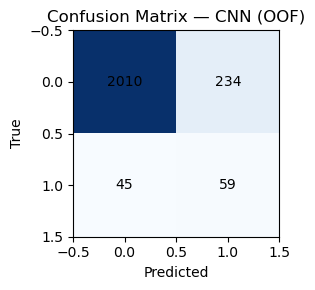


Classification report (OOF):
              precision    recall  f1-score   support

           0     0.9781    0.8957    0.9351      2244
           1     0.2014    0.5673    0.2972       104

    accuracy                         0.8812      2348
   macro avg     0.5897    0.7315    0.6162      2348
weighted avg     0.9437    0.8812    0.9068      2348

[RNN][Fold 1] Acc=0.8064 F1=0.2720 AUC=0.8379
[RNN][Fold 2] Acc=0.7851 F1=0.2171 AUC=0.7370
[RNN][Fold 3] Acc=0.7532 F1=0.1944 AUC=0.7654
[RNN][Fold 4] Acc=0.8060 F1=0.2222 AUC=0.7668
[RNN][Fold 5] Acc=0.8550 F1=0.2609 AUC=0.7845

[RNN] 5-fold CV Mean±Std:
  Accuracy : 0.8011 ± 0.0332
  F1-score : 0.2333 ± 0.0288
  ROC-AUC  : 0.7783 ± 0.0335


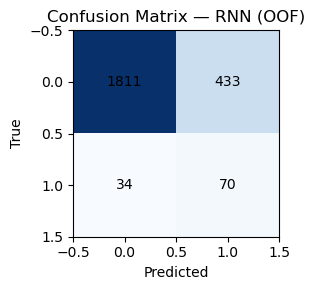


Classification report (OOF):
              precision    recall  f1-score   support

           0     0.9816    0.8070    0.8858      2244
           1     0.1392    0.6731    0.2306       104

    accuracy                         0.8011      2348
   macro avg     0.5604    0.7401    0.5582      2348
weighted avg     0.9443    0.8011    0.8568      2348



In [6]:
y_pred_cnn, y_prob_cnn, stat_cnn = train_eval_cv('cnn', max_epochs=20, batch_size=128, lr=1e-3, weight_decay=1e-4, patience=3)
y_pred_rnn, y_prob_rnn, stat_rnn = train_eval_cv('rnn', max_epochs=20, batch_size=128, lr=1e-3, weight_decay=1e-4, patience=3)


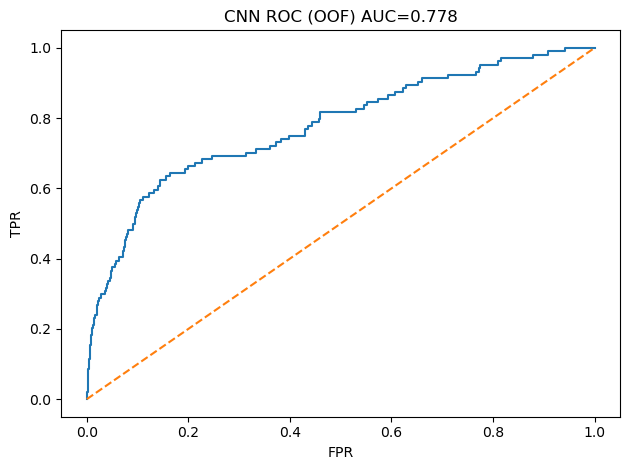

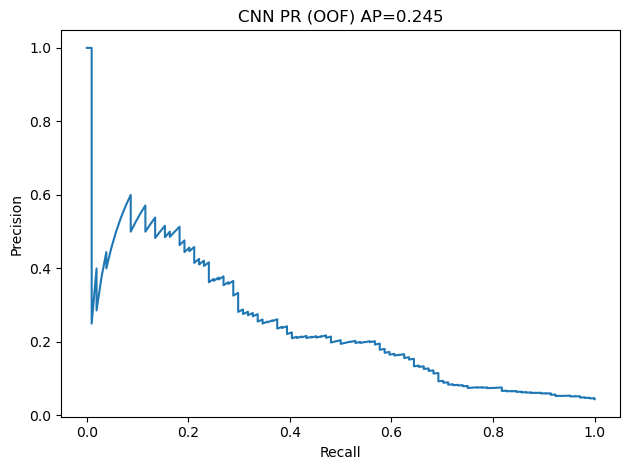

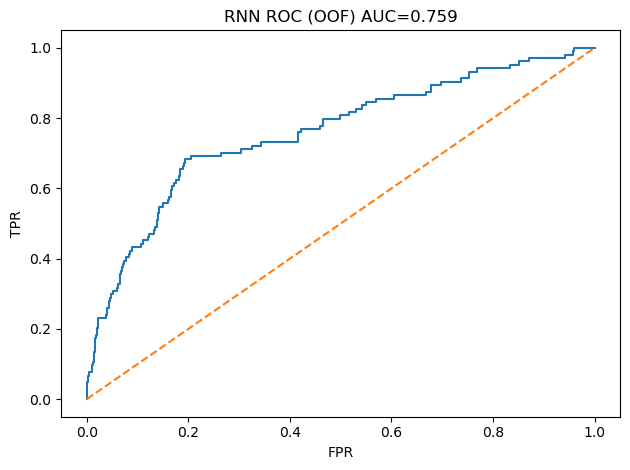

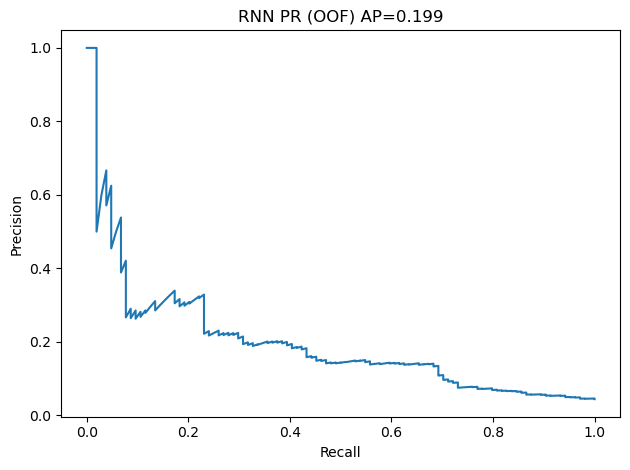

In [7]:
# G6) （可选）OOF 概率的 ROC / PR 曲线
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_curves(y_true, y_prob, title_prefix):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    pr, rc, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
    plt.title(f'{title_prefix} ROC (OOF) AUC={roc_auc:.3f}'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.tight_layout(); plt.show()

    plt.figure(); plt.plot(rc, pr)
    plt.title(f'{title_prefix} PR (OOF) AP={ap:.3f}'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.tight_layout(); plt.show()

plot_curves(y_arr, y_prob_cnn, 'CNN')
plot_curves(y_arr, y_prob_rnn, 'RNN')


In [8]:
# G7) 全量拟合 & 推理函数（与 F5 的 SVM 版本对齐）
def fit_full_model(model_name='cnn', max_epochs=25, batch_size=128, lr=1e-3, weight_decay=1e-4, patience=4):
    ds_all = SeqDataset(X_idx, y_arr)
    dl_all = DataLoader(ds_all, batch_size=batch_size, shuffle=True, drop_last=False)

    pos = float((y_arr==1).sum())
    neg = float((y_arr==0).sum())
    pos_weight = torch.tensor(neg/pos if pos>0 else 1.0, dtype=torch.float32, device=device)

    if model_name=='cnn':
        model = CNN1DClassifier(vocab_sizes).to(device)
    else:
        model = BiGRUClassifier(vocab_sizes).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_loss, best_state, no_improve = 1e9, None, 0

    for epoch in range(1, max_epochs+1):
        model.train()
        loss_tr = 0.0
        for xb, yb in dl_all:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logit = model(xb)
            loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)(logit, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            opt.step()
            loss_tr += loss.item()*xb.size(0)
        loss_tr /= len(ds_all)

        # 简单早停：看训练损失
        if loss_tr < best_loss - 1e-4:
            best_loss = loss_tr; best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    if best_state is not None:
        model.load_state_dict({k:v.to(device) for k,v in best_state.items()})

    return model

def predict_with_model(model, X_idx, threshold=0.5, batch_size=256):
    dl = DataLoader(SeqDataset(X_idx, None), batch_size=batch_size, shuffle=False)
    model.eval()
    logits = []
    with torch.no_grad():
        for xb in dl:
            xb = xb.to(device)
            logit = model(xb)
            logits.append(logit.detach().cpu().numpy())
    logit = np.concatenate(logits)
    prob  = 1/(1+np.exp(-logit))
    pred  = (prob>=threshold).astype(int)
    return pred, prob

# 训练最终模型（示例：CNN）
model_cnn_full = fit_full_model('cnn', max_epochs=25)
pred_full, prob_full = predict_with_model(model_cnn_full, X_idx, threshold=0.5)
print("全量模型（CNN）完成：示例概率/预测：", prob_full[:5], pred_full[:5])


全量模型（CNN）完成：示例概率/预测： [2.6263288e-04 2.0851341e-01 2.4553395e-03 1.3132459e-01 9.7378677e-01] [0 0 0 0 1]


In [9]:
# =========================
# Cell 8′ — 读取日历文本文件 → df_text
# =========================
import re
import pandas as pd
from pathlib import Path

# 修改为你的文件路径
FILE_PATH = Path("calendar_text_samples_zh.txt")  # ← 如果你本地运行，请改成本地路径

assert FILE_PATH.exists(), f"找不到文件：{FILE_PATH}"

records = []
with open(FILE_PATH, "r", encoding="utf-8") as f:
    lines = f.read().splitlines()

i = 0
while i < len(lines):
    header = lines[i].strip()
    if not header:
        i += 1
        continue
    # 期望 header 形如：YYYY-MM-DD(周X) [label:0/1]
    m = re.match(r"^(\d{4}-\d{2}-\d{2})\((周[一二三四五六日])\)\s*\[label:(\d)\]\s*$", header)
    if m and i + 1 < len(lines):
        date_str, weekday_str, lab = m.groups()
        text = lines[i+1].strip()
        records.append({"date": date_str, "weekday": weekday_str, "TEXT_ALL": text, "label": int(lab)})
        # 跳过空行
        i += 2
        if i < len(lines) and not lines[i].strip():
            i += 1
    else:
        # 容错：如果格式不匹配就尝试拼接为正文
        i += 1

df_text = pd.DataFrame(records)
print(f"[TextFile] 读取完成：{len(df_text)} 条")
print(df_text.head(3))
print("label 分布：", df_text["label"].value_counts().sort_index().to_dict())


[TextFile] 读取完成：1537 条
         date weekday                                           TEXT_ALL  \
0  2003-01-01      周三   午休后专心复习，完成作业按计划完成。傍晚跑步两公里，晚饭有蔬菜和肉。睡前写日记，听音乐放松再睡。   
1  2003-01-01      周三  今天深夜按时起床，喝了牛奶和面包。上课精神还可以，参加了社团活动。做了拉伸运动。作业还差一点...   
2  2003-01-01      周三    今天天气多云，心情比较放松。打了半小时篮球。和爸爸一起看节目。尝试少糖饮食。计划预习明天课程。   

   label  
0      0  
1      0  
2      0  
label 分布： {0: 1477, 1: 60}


In [10]:
# =========================
# Cell 9′ — 文本清洗 & 标签 y_text2
# =========================
import re

def _q2b(u):
    res=[]
    for ch in str(u):
        code=ord(ch)
        if code==0x3000: code=0x20
        elif 0xFF01<=code<=0xFF5E: code-=0xfee0
        res.append(chr(code))
    return ''.join(res)

# 默认不屏蔽与标签高度相关词（该合成数据中本就没有“自杀/绝望”等极端词）
TEXT_FILTER_LABEL_WORDS = False
FORBIDDEN_TOKENS2 = {'自杀','轻生','绝望'} if TEXT_FILTER_LABEL_WORDS else set()

def clean_zh2(s: str):
    if pd.isna(s): return ""
    s = _q2b(str(s)).strip()
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[^0-9A-Za-z\u4e00-\u9fa5，。？！、；：:,.!?%-/()\[\]（）【】]+', ' ', s)
    for w in FORBIDDEN_TOKENS2:
        s = s.replace(w, '')
    return s

df_text = df_text.copy()
df_text["TEXT_ALL"] = df_text["TEXT_ALL"].astype(str).map(clean_zh2)
y_text2 = df_text["label"].astype(int).copy()
print("[TextFile] 清洗完成；空文本比例：", (df_text["TEXT_ALL"].str.len()==0).mean())
print("y_text2 分布：", y_text2.value_counts().sort_index().to_dict())


[TextFile] 清洗完成；空文本比例： 0.0
y_text2 分布： {0: 1477, 1: 60}


D:\machine-learning\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
D:\machine-learning\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
D:\machine-learning\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
D:\machine-learning\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
D:\machine-learning\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[TextFile-only FIX] 5-fold CV: Acc=1.0000±0.0000 | F1=1.0000±0.0000 | AUC=1.0000±0.0000


D:\machine-learning\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
D:\machine-learning\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
D:\machine-learning\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
D:\machine-learning\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
D:\machine-learning\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



[TextFile-only FIX] Classification report (OOF):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1477
           1     1.0000    1.0000    1.0000        60

    accuracy                         1.0000      1537
   macro avg     1.0000    1.0000    1.0000      1537
weighted avg     1.0000    1.0000    1.0000      1537



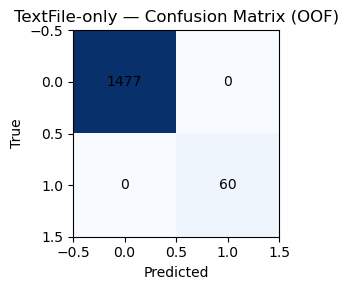

In [11]:
# =========================
# Cell 10_fix′ — 稳健版文本-only：min_df=1/max_df=1.0，确保每折都有特征
# =========================
import importlib
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 1) 分词器（有 jieba 用 jieba，否则退化）
def has_pkg(pkg):
    try:
        importlib.import_module(pkg); return True
    except: return False

USE_JIEBA2 = has_pkg('jieba')
if USE_JIEBA2:
    import jieba
    def jieba_tokenize2(s):
        return [w for w in jieba.lcut(str(s)) if w.strip()]
else:
    def jieba_tokenize2(s):
        # 无 jieba 时，word 通道作用有限，但我们有 char 通道兜底
        return [str(s)]

# 2) 更稳的向量器设置：min_df=1, max_df=1.0
word_vec2 = TfidfVectorizer(
    tokenizer=jieba_tokenize2,
    ngram_range=(1, 2),
    min_df=1,         # 关键：放宽到 1
    max_df=1.0,       # 不剪高频
    sublinear_tf=True # 轻微稳健性
)
char_vec2 = TfidfVectorizer(
    analyzer='char',
    ngram_range=(2, 5),
    min_df=1,         # 关键：放宽到 1
    max_df=1.0,
    sublinear_tf=True
)

text_union2 = FeatureUnion([('word', word_vec2), ('char', char_vec2)])

from sklearn.linear_model import LogisticRegression
text_clf2 = LogisticRegression(solver='saga', class_weight='balanced', max_iter=5000)

pipe_text2 = Pipeline([('tfidf', text_union2), ('clf', text_clf2)])

# 3) 数据与CV
assert 'df_text' in globals(), "未找到 df_text，请先运行 8′ 和 9′。"
X_text2 = df_text['TEXT_ALL'].astype(str)
y2 = df_text['label'].astype(int).values

skf2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring2 = {'acc':'accuracy', 'f1':'f1', 'roc':'roc_auc'}

cv_res2 = cross_validate(pipe_text2, X_text2, y2, cv=skf2, scoring=scoring2, return_estimator=False)
print(f"[TextFile-only FIX] 5-fold CV: "
      f"Acc={cv_res2['test_acc'].mean():.4f}±{cv_res2['test_acc'].std():.4f} | "
      f"F1={cv_res2['test_f1'].mean():.4f}±{cv_res2['test_f1'].std():.4f} | "
      f"AUC={cv_res2['test_roc'].mean():.4f}±{cv_res2['test_roc'].std():.4f}")

# OOF 预测（标签）→ 混淆矩阵 & 报告
y_pred_oof2 = cross_val_predict(pipe_text2, X_text2, y2, cv=skf2, method='predict')
print("\n[TextFile-only FIX] Classification report (OOF):")
print(classification_report(y2, y_pred_oof2, digits=4, zero_division=0))
cm2 = confusion_matrix(y2, y_pred_oof2)
plt.figure(figsize=(4,3))
plt.imshow(cm2, cmap='Blues'); plt.title('TextFile-only — Confusion Matrix (OOF)')
plt.xlabel('Predicted'); plt.ylabel('True')
for (i,j), v in np.ndenumerate(cm2): plt.text(j,i,int(v),ha='center',va='center')
plt.tight_layout(); plt.show()


In [12]:
# =========================
# Cell 11′ — 全量拟合 & 重要词
# =========================
pipe_text_final2 = pipe_text2.fit(df_text['TEXT_ALL'].astype(str), y2)

vec_union2 = pipe_text_final2.named_steps['tfidf']
clf2 = pipe_text_final2.named_steps['clf']

feats2 = []
for name, vec in [('word', vec_union2.transformer_list[0][1]),
                  ('char', vec_union2.transformer_list[1][1])]:
    vocab = vec.get_feature_names_out()
    feats2.extend([f"{name}:{t}" for t in vocab])

coefs2 = clf2.coef_.ravel()
topN = 30
idx_pos2 = np.argsort(coefs2)[-topN:][::-1]
idx_neg2 = np.argsort(coefs2)[:topN]

print("\n[TextFile-only] Top positive tokens (→ Risk=1):")
for i in idx_pos2:
    print(f"{feats2[i]}\t{coefs2[i]:.4f}")

print("\n[TextFile-only] Top negative tokens (→ Safe=0):")
for i in idx_neg2:
    print(f"{feats2[i]}\t{coefs2[i]:.4f}")


D:\machine-learning\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



[TextFile-only] Top positive tokens (→ Risk=1):
char:担心	0.7329
char:最近	0.6520
char:白天	0.6265
char:胃口	0.6121
char:注意	0.5904
char:注意力	0.5904
char:意力	0.5904
word:今天上午情绪烦躁,整天犯困。不想运动,也不太想和同学说话。想起被起外号。胃口变差,早饭没吃。晚上躺着一直想事情,睡了5小时不到。	0.5649
word:今天深夜情绪低落,非常疲惫。不想去跑步,也不太想和同学说话。担心被嘲笑。胃口没有胃口,随便吃了饼干。晚上躺着反复回想不开心的事,睡了6小时不到。	0.5560
char:不想	0.5469
word:今天上午情绪低落,整天犯困。不想运动,也不太想和同学说话。想起被起外号。胃口忽好忽坏,随便吃了饼干。晚上躺着反复回想不开心的事,睡了4小时不到。	0.5436
word:最近作业堆积,一想到考试就胸口发紧。不想多说减少,怕他们担心。周末几乎不出门,看短视频超过两三小时。感觉被疏远。	0.5305
char:太想	0.5223
char:话。	0.5223
char:说话。	0.5223
char:说话	0.5223
char:不太	0.5223
char:不太想	0.5223
word:今天晚上情绪焦虑,整天犯困。不想去跑步,也不太想和同学说话。想起被起外号。胃口忽好忽坏,只喝了水。晚上躺着一直想事情,睡了4小时不到。	0.5210
word:白天总是提不起精神,注意力总是走神。躲着人群。偶尔会冒出 想躲起来 的想法,但知道要保护自己。想尝试降低夜间刷手机时间来调整作息。	0.5173
char:老师	0.5171
word:白天总是整天犯困,注意力脑子像被雾挡住。不太想说话。偶尔会冒出 不想见人 的想法,但知道要保护自己。想尝试找老师/心理老师聊聊来调整作息。	0.5171
word:最近复习赶不完,一想到考试就胃不舒服。不想多说减少,怕他们担心。周末几乎不出门,刷手机超过两三小时。感觉被疏远。	0.5121
word:今天上午情绪低落,整天犯困。不想运动,也不太想和同学说话。想起被起外号。胃口没有胃口,随便吃了饼干。晚上躺着反复回想不开心的事,睡了5小时不到。	0.5096
word:最近作业堆积,一

In [13]:
# =========================
# Cell 12′ — 个体级解释（coef×tfidf）
# =========================
from scipy.sparse import issparse
import numpy as np

Xv_all2 = vec_union2.transform(df_text['TEXT_ALL'].astype(str))
if issparse(Xv_all2): Xv_all2 = Xv_all2.tocsr()

def explain_text_for_indices2(indices, topk=10):
    for idx in indices:
        rowpos = df_text.index.get_loc(idx)
        row = Xv_all2[rowpos]
        nz = row.nonzero()[1]
        contrib = [(feats2[j], row[0, j]*coefs2[j]) for j in nz]
        contrib.sort(key=lambda x: x[1], reverse=True)
        print(f"\n[Index {idx}] label={int(df_text.loc[idx,'label'])} 文本贡献 Top{topk}:")
        for t, val in contrib[:topk]:
            print(f"  {t}\t{val:.4f}")

# 示例：随机抽 3 个正类 + 3 个负类
pos_idx2 = df_text.index[df_text['label']==1].tolist()[:3]
neg_idx2 = df_text.index[df_text['label']==0].tolist()[:3]
indices_demo = pos_idx2 + neg_idx2
if len(indices_demo)>0:
    explain_text_for_indices2(indices_demo, topk=12)
else:
    print("样本太少，无法解释。")



[Index 63] label=1 文本贡献 Top12:
  word:白天总是非常疲惫,注意力很难集中注意力。躲着人群。偶尔会冒出 想躲起来 的想法,但会主动求助。想尝试降低夜间刷手机时间来调整作息。	0.4204
  char:注意力	0.0540
  char:注意	0.0540
  char:意力	0.0540
  char:白天	0.0316
  char:总是	0.0275
  char:调整作息	0.0271
  char:调整作	0.0271
  char:调整	0.0271
  char:整作息	0.0271
  char:整作	0.0271
  char:作息	0.0271

[Index 67] label=1 文本贡献 Top12:
  word:最近复习赶不完,一想到考试就胸口发紧。怕让他们担心减少,怕他们担心。周末几乎不出门,打游戏超过三四小时。感觉被疏远。	0.4116
  char:担心	0.0706
  char:们担心	0.0479
  char:们担	0.0479
  char:他们担心	0.0479
  char:他们担	0.0479
  char:他们	0.0479
  char:最近	0.0350
  char:门,	0.0239
  char:超过	0.0239
  char:试就	0.0239
  char:考试就	0.0239

[Index 77] label=1 文本贡献 Top12:
  word:最近作业堆积,一想到考试就头疼。怕让他们担心减少,怕他们担心。周末几乎不出门,看短视频超过三四小时。感觉被疏远。	0.5083
  char:担心	0.0710
  char:们担心	0.0482
  char:们担	0.0482
  char:他们担心	0.0482
  char:他们担	0.0482
  char:他们	0.0482
  char:最近	0.0352
  char:门,	0.0240
  char:超过	0.0240
  char:试就	0.0240
  char:考试就	0.0240

[Index 0] label=0 文本贡献 Top12:
  char:记,听音乐	-0.0050
  char:记,听音	-0.0050
  char:记,听	-0.0050
  char:日记,听音	

In [14]:
# =========================
# Cell 13′ — LDA（Risk=1 子集）
# =========================
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import importlib

USE_JIEBA2 = has_pkg('jieba')
if USE_JIEBA2:
    import jieba
    def jieba_tokenize2(s):
        return [w for w in jieba.lcut(str(s)) if w.strip()]
else:
    def jieba_tokenize2(s):
        return str(s).split()

X_pos2 = df_text.loc[df_text['label']==1, 'TEXT_ALL'].astype(str)
if (X_pos2.str.len()>0).sum() < 10:
    print("正类文本太少，跳过 LDA。")
else:
    bow2 = CountVectorizer(tokenizer=jieba_tokenize2, min_df=3, max_df=0.9)
    Xbow2 = bow2.fit_transform(X_pos2)
    n_topics2 = min(5, max(2, Xbow2.shape[0]//50))
    lda2 = LatentDirichletAllocation(n_components=n_topics2, learning_method='batch', random_state=42)
    W2 = lda2.fit_transform(Xbow2)
    H2 = lda2.components_
    vocab2 = np.array(bow2.get_feature_names_out())

    print(f"[LDA] 主题数：{n_topics2}")
    for k in range(n_topics2):
        topw = vocab2[np.argsort(H2[k])[::-1][:12]]
        print(f"Topic {k}: {' '.join(topw)}")


[LDA] 主题数：2
Topic 0: 不想见人 的想法,但知道要保护自己。想尝试调整作息与计划来调整作息。 想躲起来 如果自己能消失就好了 的想法,但会主动求助。想尝试降低夜间刷手机时间来调整作息。
Topic 1: 想躲起来 如果自己能消失就好了 的想法,但会主动求助。想尝试降低夜间刷手机时间来调整作息。 的想法,但知道要保护自己。想尝试调整作息与计划来调整作息。 不想见人


D:\machine-learning\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [15]:
# =========================
# Cell 14′ — 直接用你上面已有的 pipe_text_final 做外推（如存在）
# =========================
import numpy as np

if 'pipe_text_final' in globals():
    # 注意：上面的 pipe_text_final 是在真实问卷的 TEXT 上训练的；
    # 直接外推到这个“日历体”语域可能性能偏移，只作参考
    proba_out = pipe_text_final.predict_proba(df_text['TEXT_ALL'])[:,1]
    pred_out  = (proba_out >= 0.5).astype(int)
    acc_out = (pred_out == df_text['label'].values).mean()
    print(f"[外推到日历文本] 使用 pipe_text_final 的 Accuracy: {acc_out:.4f}")
    df_text_out = df_text.copy()
    df_text_out['proba_risk_from_old_model'] = proba_out
    # 你可以 df_text_out.sort_values('proba_risk_from_old_model', ascending=False).head(10)
else:
    print("未检测到 pipe_text_final（你可以只使用 10′–13′ 的就地训练结果）。")


未检测到 pipe_text_final（你可以只使用 10′–13′ 的就地训练结果）。


In [18]:
# =========================
# Cell 15′ — 交互测试：输入任意中文文本 → 概率 & 解释
# =========================
import numpy as np
import pandas as pd
from scipy.sparse import issparse

# 选择模型：'calendar' 用 11′ 训练的 pipe_text_final2；'survey' 用 11 训练的 pipe_text_final
MODEL_SOURCE = 'calendar'   # ← 需要就改成 'survey'

# 预处理函数：优先用 9′ 的 clean_zh2，其次用 8 的 clean_zh，最后用轻量兜底
def _fallback_clean(s: str):
    import re
    s = str(s).strip()
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'[^0-9A-Za-z\u4e00-\u9fa5，。？！、；：:,.!?%-/()\[\]（）【】]+', ' ', s)
    return s

if 'clean_zh2' in globals():
    _clean = clean_zh2
elif 'clean_zh' in globals():
    _clean = clean_zh
else:
    _clean = _fallback_clean

# 取模型与向量器、特征名、系数
if MODEL_SOURCE == 'calendar':
    assert 'pipe_text_final2' in globals(), "找不到 pipe_text_final2，请先运行 11′。"
    model = pipe_text_final2
    vec_union = model.named_steps['tfidf']
    clf = model.named_steps['clf']
    # 构造特征名
    feats = []
    for name, vec in [('word', vec_union.transformer_list[0][1]),
                      ('char', vec_union.transformer_list[1][1])]:
        vocab = vec.get_feature_names_out()
        feats.extend([f"{name}:{t}" for t in vocab])
    coefs = clf.coef_.ravel()
elif MODEL_SOURCE == 'survey':
    assert 'pipe_text_final' in globals(), "找不到 pipe_text_final，请先运行 Cell 11（问卷文本模型）。"
    model = pipe_text_final
    vec_union = model.named_steps['tfidf']
    clf = model.named_steps['clf']
    feats = []
    for name, vec in [('word', vec_union.transformer_list[0][1]),
                      ('char', vec_union.transformer_list[1][1])]:
        vocab = vec.get_feature_names_out()
        feats.extend([f"{name}:{t}" for t in vocab])
    coefs = clf.coef_.ravel()
else:
    raise ValueError("MODEL_SOURCE 只能是 'calendar' 或 'survey'。")

def predict_text_prob(text: str, topk=20, threshold=0.6, show_negative=10):
    """对一段文本输出：风险概率、判定、Top 贡献词（正/负）"""
    t = _clean(text)
    df_in = pd.DataFrame({'TEXT_ALL': [t]})
    proba = float(model.predict_proba(df_in['TEXT_ALL'])[0,1])
    pred  = int(proba >= threshold)
    print(f"预测抑郁风险概率: {proba:.4f}  → 判定: {'Risk=1' if pred==1 else 'Safe=0 无抑郁风险'} (阈值={threshold:.2f})")

    # 解释：coef × tfidf
    Xv = vec_union.transform(df_in['TEXT_ALL'])
    if issparse(Xv): Xv = Xv.tocsr()
    row = Xv[0]
    nz = row.nonzero()[1]
    contrib = [(feats[j], row[0, j]*coefs[j]) for j in nz]
    contrib.sort(key=lambda x: x[1], reverse=True)

    print(f"\nRisk_Trend Top{topk} words & Contribution：")
    for tkn, val in contrib[:topk]:
        print(f"  {tkn}\t{val:.4f}")

    if show_negative and show_negative > 0:
        neg = sorted(contrib, key=lambda x: x[1])[:show_negative]
        print(f"\nSafe_Trend Top{show_negative} words & Contribution：")
        for tkn, val in neg:
            print(f"  {tkn}\t{val:.4f}")

# Test with example text
example_text = "我一直在哭😭我一直在哭😭我躯体化了😭我抑郁症了😭我一直在哭😭我一直在哭😭我躯体化了😭我抑郁症了😭我一直在哭😭我一直在哭😭我躯体化了😭我抑郁症了😭我一直在哭😭我一直在哭😭我躯体化了😭我抑郁症了😭。"
predict_text_prob(example_text, topk=15, threshold=0.4, show_negative=8)


预测抑郁风险概率: 0.3874  → 判定: Safe=0 无抑郁风险 (阈值=0.40)

Risk_Trend Top15 words & Contribution：
  char:一直	0.1299
  char:了 	0.0835

Safe_Trend Top8 words & Contribution：
  char:了 	0.0835
  char:一直	0.1299


In [21]:
%pip install -q streamlit plotly scikit-learn pandas numpy joblib


Note: you may need to restart the kernel to use updated packages.


In [23]:
# === SAVE_BEHAVIOR_MODEL ===
# 目标：
# 1) 优先保存你内存里已有的行为模型管道（SVM+PCA 那个）；
# 2) 若找不到，则用 df / behavior_feature_cols / y_bin 一键重训一个 SVM+PCA，并保存；
# 3) 同时导出 meta.json（包含模型使用到的列名），供 app.py 生成问卷控件与基线统计。

import json, joblib, numpy as np, pandas as pd
from pathlib import Path

# ---------- 你可以改这两个导出文件名 ----------
OUT_PKL  = "svm_pca_behavior_pipeline.pkl"
OUT_META = "svm_pca_behavior_meta.json"

# ---------- 尝试从内存里找到一个“看起来像行为模型”的 sklearn Pipeline ----------
_behavior_pipe = None
for name, obj in list(globals().items()):
    try:
        from sklearn.pipeline import Pipeline
        if isinstance(obj, Pipeline):
            # 简单启发式：包含 PCA 或 ColumnTransformer + SVC
            step_names = [s for s,_ in obj.steps]
            if any("pca" in s.lower() for s in step_names) or any("svc" in s.lower() for s in step_names):
                _behavior_pipe = obj
                print(f"🟢 发现已训练的 Pipeline: {name} -> {step_names}")
                break
    except Exception:
        pass

# ---------- 如果找不到，就按既定方案重训一个 ----------
if _behavior_pipe is None:
    print("ℹ️ 未发现已训练的行为 Pipeline，将按既定配置重训一个 SVM+PCA 管道用于导出。")
    # 1) 保障 df / y_bin
    assert 'df' in globals(), "未找到 df，请先运行你的数据加载单元。"
    if 'y_bin' not in globals():
        # 兜底按 Q38/Q39 生成二分类标签（1=Risk）
        def _norm_token(x):
            s = str(x).strip().lower()
            try:
                f = float(s); 
                if float(int(f)) == f: return str(int(f))
                return s
            except: return s
        YES = {'yes','y','true','是','有','2','2.0'}
        def _is_yes(v): 
            s = _norm_token(v)
            return (s in YES)
        q38 = df['Q38'] if 'Q38' in df.columns else None
        q39 = df['Q39'] if 'Q39' in df.columns else None
        assert (q38 is not None) or (q39 is not None), "没有 Q38/Q39，无法兜地生成标签。"
        y_bin = ((q39.map(_is_yes) if q39 is not None else False) | (q38.map(_is_yes) if q38 is not None else False)).astype(int)
        print("✅ 兜底生成 y_bin 完成。分布：", y_bin.value_counts().to_dict())

    # 2) 保障行为特征列
    if 'behavior_feature_cols' in globals() and len(behavior_feature_cols) > 0:
        feats = list(behavior_feature_cols)
        print(f"🟢 使用已有行为特征列 {len(feats)} 个。")
    else:
        # 轻量启发式：拿所有以 'Q' 开头的列，去掉 Q38/39/40 和明显人口学/体测
        ban = {'Q38','Q39','Q40'}
        ban_kw = ['height','weight','身高','体重','bmi','年龄','年级','性别','男','女','grade','age','sex','gender','班','id','编号']
        candidates = [c for c in df.columns if str(c).upper().startswith('Q') and c not in ban]
        feats = []
        for c in candidates:
            cname = str(c).lower()
            if any(k in cname for k in ban_kw): 
                continue
            # 丢掉几乎全空/全常数
            s = df[c]
            if s.notna().sum() < 50: 
                continue
            if pd.api.types.is_numeric_dtype(s):
                if s.nunique(dropna=True) < 2:
                    continue
            feats.append(c)
        print(f"🟡 behavior_feature_cols 不存在，启发式选出 {len(feats)} 个候选行为列。")

    # 3) 构建并拟合 SVM+PCA 管道
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.decomposition import PCA
    from sklearn.svm import SVC
    from sklearn.pipeline import Pipeline

    X = df[feats].copy()

    num_cols = X.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
    cat_cols = [c for c in feats if c not in num_cols]

    pre = ColumnTransformer([
        ('num', Pipeline([('impute', SimpleImputer(strategy='median')),
                          ('scale',  StandardScaler())]), num_cols),
        ('cat', Pipeline([('impute', SimpleImputer(strategy='most_frequent')),
                          ('ohe',    OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
    ], remainder='drop')

    _behavior_pipe = Pipeline([
        ('prep', pre),
        ('pca',  PCA(n_components=0.95, svd_solver='full', random_state=42)),
        ('svc',  SVC(kernel='rbf', probability=True, class_weight='balanced', C=2.0, gamma='scale', random_state=42))
    ])

    _behavior_pipe.fit(X, y_bin)
    print("✅ 重训完成。")

# ---------- 保存模型 ----------
joblib.dump(_behavior_pipe, OUT_PKL)
print(f"💾 已保存行为模型到: {OUT_PKL}")

# ---------- 保存元数据（特征列表） ----------
# 尝试从 ColumnTransformer 恢复原始列；否则用 behavior_feature_cols / feats
model_features = None
try:
    from sklearn.compose import ColumnTransformer
    pre = _behavior_pipe.named_steps.get('prep', None)
    if isinstance(pre, ColumnTransformer):
        # 还原 ColumnTransformer 里声明的列集合
        model_features = []
        for name, trans, cols in pre.transformers_:
            if cols is not None:
                model_features.extend(list(cols))
        model_features = list(dict.fromkeys(model_features))
except Exception:
    pass

if model_features is None:
    if 'behavior_feature_cols' in globals() and len(behavior_feature_cols) > 0:
        model_features = list(behavior_feature_cols)
    elif 'feats' in locals():
        model_features = list(feats)
    else:
        model_features = []

meta = {"features": model_features}
with open(OUT_META, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print(f"💾 已保存元数据到: {OUT_META}")
print("📦 导出完成。可在 app.py 侧边栏指向这两个文件。")


ℹ️ 未发现已训练的行为 Pipeline，将按既定配置重训一个 SVM+PCA 管道用于导出。
🟢 使用已有行为特征列 40 个。
✅ 重训完成。
💾 已保存行为模型到: svm_pca_behavior_pipeline.pkl
💾 已保存元数据到: svm_pca_behavior_meta.json
📦 导出完成。可在 app.py 侧边栏指向这两个文件。


In [29]:
%cd "/AAAcss project"


[WinError 2] 系统找不到指定的文件。: '/AAAcss project'
C:\Users\wdy\AAAcss project


In [3]:
# 杀掉占用 8501 的进程（若无占用不会报错）
!powershell -Command "$p=(Get-NetTCPConnection -LocalPort 8501 -ErrorAction SilentlyContinue).OwningProcess; if($p){Write-Host ('Killing PID ' + $p); Stop-Process -Id $p -Force}"

# 杀掉占用 8502 的进程
!powershell -Command "$p=(Get-NetTCPConnection -LocalPort 8502 -ErrorAction SilentlyContinue).OwningProcess; if($p){Write-Host ('Killing PID ' + $p); Stop-Process -Id $p -Force}"

# 保险：按命令行参数查找并结束“streamlit run app.py”相关进程
!powershell -Command "Get-CimInstance Win32_Process | Where-Object {$_.CommandLine -like '*streamlit*run*app.py*'} | ForEach-Object {Stop-Process -Id $_.ProcessId -Force}"





  You can now view your Streamlit app in your browser.

  URL: http://127.0.0.1:8630



In [10]:
# 进入 app.py 所在目录（你的截图显示这个）
%cd "/"

# 安装依赖（若已装过会很快）
%pip install -q streamlit plotly scikit-learn pandas numpy joblib

# 启动 Streamlit（绑定到 127.0.0.1，固定新端口 8630，避免冲突）
!python -m streamlit run app.py --server.headless true --server.address 127.0.0.1 --server.port 8630


C:\
Note: you may need to restart the kernel to use updated packages.


Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py


In [11]:
!python -m streamlit run app.py --server.headless true --server.address 127.0.0.1 --server.port 8630

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py
